# Human-AI Image Detection Model Training

This notebook implements the training pipeline for detecting AI-generated vs human-created images.

In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import torch
import mlflow
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.model_factory import ModelFactory
from src.data.human_ai_dataset import HumanVSAIDataset
from src.training.trainer import ModelTrainer
import torch.utils.data.dataset
import random
import torch.utils
import torch.utils.data
from src.utils.model_utils import save_model


## Configuration

In [2]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')
print("Loaded configuration")
# print(yaml.dump(config, default_flow_style=False))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded configuration


## Data Loading and Preprocessing

In [3]:
labels_map = {
    0: 'Human generated',
    1: 'AI generated'
}

# NOTE: use this for validation set
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     # transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                         std=[0.5, 0.5, 0.5])
# ])

transform = transforms.Compose([
    # Random crop and resize the image to 128x128
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),  # Random rotation within a range of -30 to +30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
    # transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image to [-1, 1]
])

dataset = HumanVSAIDataset(
    annotations_file_path=config['dataset']['train_csv'],
    transform=transform
)

trainset_size = 1 - config['dataset']['test_split']
trainset_size = int(len(dataset) * trainset_size)
valset_size = int(len(dataset) - trainset_size)

trainset, valset = torch.utils.data.random_split(dataset, [trainset_size, valset_size])

print(f"Total trainset size: {len(dataset)}")
print(f"Training dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")

trainloader = torch.utils.data.DataLoader(trainset)

Total trainset size: 79950
Training dataset size: 55965
Validation dataset size: 23985


## Visualize Sample Images

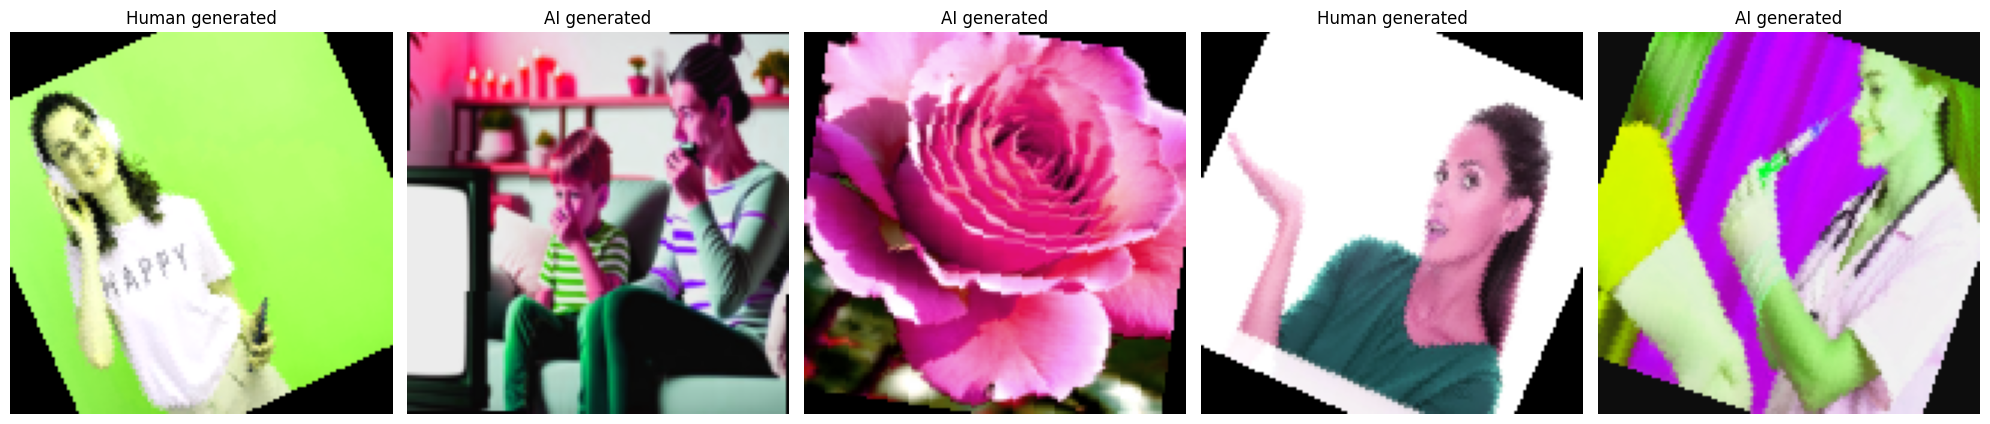

In [4]:
def show_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img, label = dataset[i]


        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy() 

        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].set_title(labels_map[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(trainset)

## Model Training and Hyperparameter Tuning

**NOTE**: Uncommet the below code to test your model working on a smaller subset

In [18]:
# trainset_size = len(trainset)
# indices = random.sample(range(trainset_size), 10)
# trainset = torch.utils.data.dataset.Subset(trainset, indices)

In [19]:
%load_ext autoreload
%autoreload 2

model_factory = ModelFactory()
trainer = ModelTrainer(config, model_factory)

# Perform hyperparameter tuning
best_params, best_score, final_model = trainer.train_and_tune(trainset)

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
save_model(best_params, best_score, final_model, 'deep_cnn')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Skipping hyperparameter tuning and using default parameters.
Training deep_cnn with default parameters
Performing KFold Cross Validation with 3 folds
Epoch 1


Training: 100%|██████████| 1166/1166 [08:24<00:00,  2.31it/s, loss=0.313, acc=87.5]


Epoch 2


Training: 100%|██████████| 1166/1166 [09:35<00:00,  2.03it/s, loss=0.235, acc=91.3]


Epoch 3


Training: 100%|██████████| 1166/1166 [10:22<00:00,  1.87it/s, loss=0.201, acc=92.6]


Accuracy obtained on Fold 1: 0.9310640578933261
Epoch 1


Training: 100%|██████████| 1166/1166 [10:55<00:00,  1.78it/s, loss=0.171, acc=94]  


Epoch 2


Training: 100%|██████████| 1166/1166 [10:42<00:00,  1.81it/s, loss=0.12, acc=95.8] 


Epoch 3


Training: 100%|██████████| 1166/1166 [10:44<00:00,  1.81it/s, loss=0.0921, acc=96.8]


Accuracy obtained on Fold 2: 0.9777539533637095
Epoch 1


Training: 100%|██████████| 1166/1166 [06:49<00:00,  2.85it/s, loss=0.0798, acc=97.4]


Epoch 2


Training: 100%|██████████| 1166/1166 [06:50<00:00,  2.84it/s, loss=0.0712, acc=97.6]


Epoch 3


Training: 100%|██████████| 1166/1166 [06:49<00:00,  2.85it/s, loss=0.0527, acc=98.2]


Accuracy obtained on Fold 3: 0.9854194585901903
Mean score obtained from KFold: 0.9647458232824087
Best parameters: {'in_channels_list': [3, 32, 64, 128], 'out_channels_list': [32, 64, 128, 256], 'kernel_size_list': [3, 3, 3, 3], 'dropout_rate': 0.5}
Best score: 0.9647458232824087
Model saved to trained_models/deep_cnn.pt


## Training Visualization

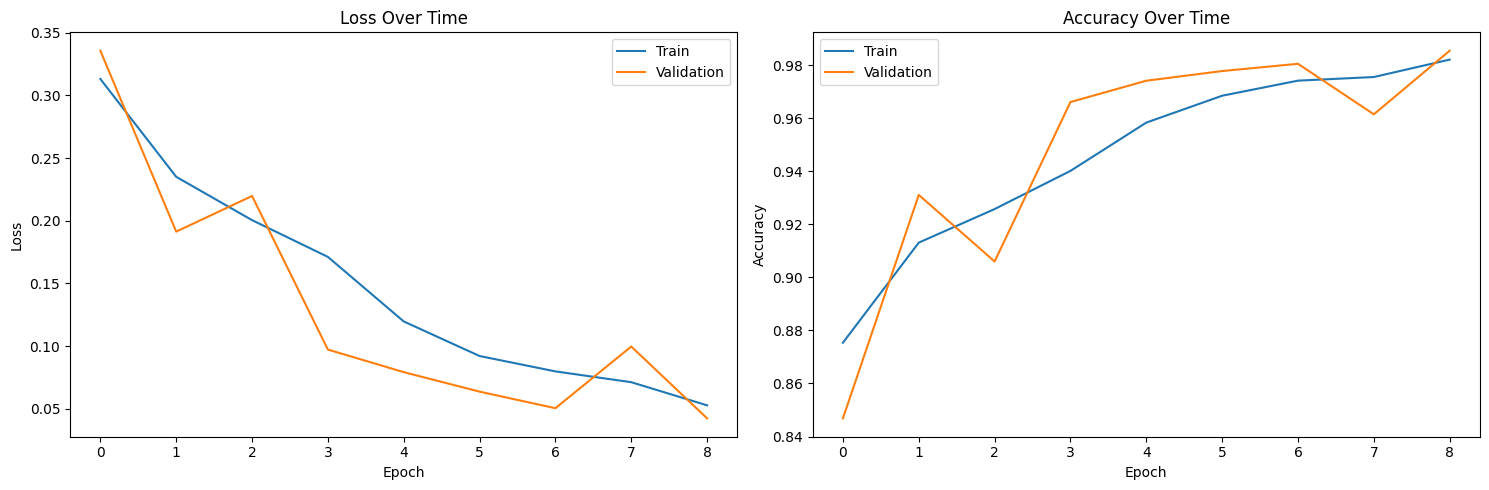

In [20]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Validation')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Validation')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(trainer.history)

In [21]:
valloader = torch.utils.data.DataLoader(valset)
val_loss, val_acc = trainer._evaluate(final_model, valloader)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

Validation Loss: 0.047875651553254836
Validation Accuracy: 0.982614133833646


/Users/prashanthjaganathan/Desktop/CS6140 - ML/GeneratedImageDetector/human-ai-image-detection/src/training/trainer.py:363: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  che

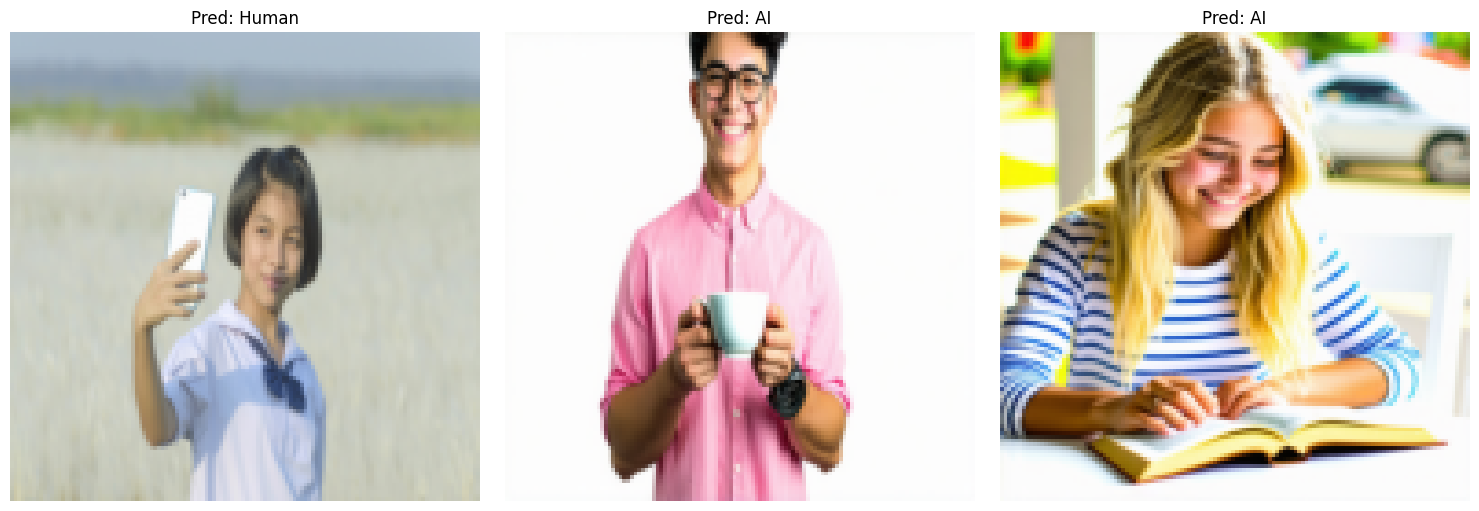

In [5]:
model_factory = ModelFactory()
model_name = config['model_names'][0]

base_params = config['models'][model_name].get('base_params') or {}  # Fallback to empty dict if None
model = model_factory.get_model(model_name, **base_params)
model_path = "trained_models/hybrid_classifier.pt"

ModelTrainer.test_random(
    model_path=model_path,
    model=model,
    num_images=3,
    csv_path="dataset/test.csv"
)